### Model Ensemble 

At this point we have finalized hyperparameter tuning of various models and we will decide on final prediction model or blending multiple models for better prediction.

#### Loading data sets

In [1]:
import pickle
# Load Validation set
disk = "D:\Data_science\GitHub\Predictive-Modeling-510k-decision-time"
# Validation set 
with open(disk+"\X_val.pkl","rb") as f:
    X_val=pickle.load(f)

with open(disk+"\y_val.pkl","rb") as f:
    y_val=pickle.load(f)

#### Loading model objects

We will retrieve different model objects we trained.

In [2]:
import pickle

#lgbm
disk_tree = "tree"
with open(disk_tree + "/lgbm1_model.pkl", "rb") as f:
    lgbm= pickle.load(f)

print("Loaded lgbm model.")    
print("*" * 40)

# Ridge
disk_ridge = "ridge"
with open(disk_ridge + "/ridge1_model.pkl", "rb") as f:
    ridge = pickle.load(f)
    
print("Loaded ridge model.")    
print("*" * 40)

# keras nnet model:
from keras.models import load_model 
disk_nnet = "nnet"
network = load_model((disk_nnet + "/network1.h5"))

print("Loaded nnet model.")    
print("*" * 40)

# svr model:
disk_svr = 'svr'
with open(disk_svr + "/svr_model.pkl", "rb") as f:
    svr=pickle.load(f)
    
print("Loaded svr model.")    
print("*" * 40)    

Loaded lgbm model.
****************************************
Loaded ridge model.
****************************************


C:\Users\OZAN\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loaded nnet model.
****************************************
Loaded svr model.
****************************************


#### Collect predictions

Let's collect model validation predictions and true target into a single data frame:

In [3]:
# Load model-specific processed validation sets
#lgbm
disk_tree = "tree"
with open(disk_tree + "\X_val_trans_tree3.pkl", "rb") as f:
    X_val_lgbm= pickle.load(f)

print("Loaded lgbm model.")    
print("*" * 40)

# Ridge
disk_ridge = "ridge"
with open(disk_ridge + "\X_val_trans_ridge.pkl", "rb") as f:
    X_val_ridge = pickle.load(f) 
    
print("Loaded ridge model.")    
print("*" * 40)

# keras nnet model:
disk_nnet = "nnet"
with open(disk_nnet + "\X_val_trans_NNet.pkl", "rb") as f:
    X_val_NNet = pickle.load(f) 

print("Loaded nnet model.")    
print("*" * 40)

# svr model:
disk_svr = 'svr'
with open(disk_svr + "\X_val_trans_SVM.pkl", "rb") as f:
    X_val_SVM = pickle.load(f) 
    
print("Loaded svr model.")    
print("*" * 40) 


Loaded lgbm model.
****************************************
Loaded ridge model.
****************************************
Loaded nnet model.
****************************************
Loaded svr model.
****************************************


In [4]:
import numpy as np
import pandas as pd
target_predictions = pd.DataFrame()
target_predictions['y_val'] = y_val
target_predictions['preds_ridge'] = np.exp(ridge.predict(X_val_ridge))
target_predictions["preds_lgbm"] = np.exp(lgbm.predict(X_val_lgbm))
target_predictions['preds_svr'] = np.exp(svr.predict(X_val_SVM))
target_predictions['preds_nnet'] = np.exp(network.predict(X_val_NNet))                     

In [5]:
target_predictions.head()

,y_val,preds_ridge,preds_lgbm,preds_svr,preds_nnet
1570,60,86.247122,80.549508,82.149822,104.505730
6715,83,104.032377,94.826861,73.038617,123.458801
15618,135,114.790733,82.224527,73.301442,104.345695
2740,42,36.724651,30.301231,38.323165,68.422867
22016,27,43.986322,39.922117,39.991656,34.047577


In [46]:
from sklearn.metrics import median_absolute_error
# Mean predictions ensemble
mean_preds = target_predictions.drop(["y_val"], axis= 1).apply(np.mean, axis = 1)
# Median predictions ensemble
median_preds = target_predictions.drop(["y_val"], axis= 1).apply(np.median, axis = 1)

In [47]:
median_absolute_error(target_predictions.y_val,median_preds)

30.557487662155296

In [86]:
def plot_performance(true, preds, model_name):    
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import median_absolute_error 
    mae = median_absolute_error(true,preds)
    plt.scatter(x = preds, y = true, c = 'blue', s = 3, alpha = 0.015)
    plt.xlim(-20,1300)
    plt.ylim(-20,1300)
    plt.plot([0,1200],[0,1200], "--k")
    plt.xlabel("Predictions")
    plt.ylabel("True targets")
    plt.text(0,1100, r"MAE = %.2f"%(mae))
    plt.title("Predictive performance of "+ model_name + " model" )

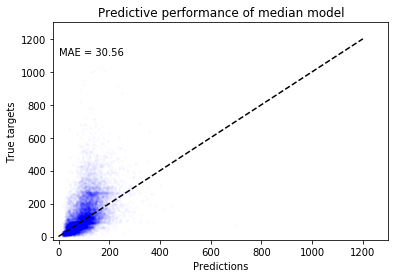

In [87]:
plot_performance(target_predictions.y_val,median_preds,"median")

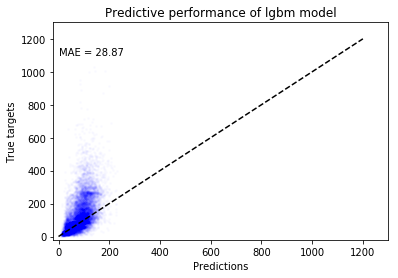

In [88]:
plot_performance(target_predictions.y_val,target_predictions.preds_lgbm,"lgbm")

#### Ensemble model using validation predictions

At this stage we will try to use predictions from 4 models to train new models and estimate the error using cross-validation.

In [6]:
X_ens = target_predictions.drop(["y_val"], axis = 1)
X_ens.head()

,preds_ridge,preds_lgbm,preds_svr,preds_nnet
1570,86.247122,80.549508,82.149822,104.505730
6715,104.032377,94.826861,73.038617,123.458801
15618,114.790733,82.224527,73.301442,104.345695
2740,36.724651,30.301231,38.323165,68.422867
22016,43.986322,39.922117,39.991656,34.047577


In [7]:
# Adding polynomial interaction terms
from sklearn.preprocessing import PolynomialFeatures
X_ens = PolynomialFeatures(degree=3).fit_transform(X_ens)

In [8]:
print(X_ens.shape)

(15899, 35)


In [28]:
import lightgbm as lgbm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error, make_scorer

def my_score(preds,y_true):
    return median_absolute_error(y_true,preds)

custom_score = make_scorer(score_func= my_score, greater_is_better= False)

estimator = lgbm.LGBMRegressor(n_estimators= 200, num_leaves= 100,boosting_type= 'rf')

cross_val_score(estimator,X = X_ens, y= y_val, scoring= custom_score, cv = 100)


LightGBMError: b'Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at c:\\projects\\lightgbm\\python-package\\compile\\src\\boosting\\rf.hpp, line 29 .\n'

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error, make_scorer

def my_score(preds,y_true):
    return median_absolute_error(y_true,preds)

custom_score = make_scorer(score_func= my_score, greater_is_better= False)

estimator = LinearSVR()

cross_val_score(estimator,X = X_ens, y= y_val, scoring= custom_score, cv = 100)